##Building a Sentiment Classifier Based on the Tweet Sentiment Extraction Dataset

**Objectives:**

1. Perform dataset EDA.
1. Perform text data vectorization using both Bag-of-Words and TF-IDF methods.
1. Compare the two vectorization methods.
1. Build a classifier based on the vectorized data.
1. Conduct an error analysis.

**Dataset:**
Data from Kaggle competition: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Download dataset from Google Drive: https://drive.google.com/file/d/1m6z3gkNKXAcKtxX5bPRLrJHtlLh7oc9I/view?usp=sharing



### Step 1. Loading and Exploring the Dataset

Steps:
* Load the dataset train.csv and examine its structure.
* Display the first 5 rows and basic statistics, including record count, column types, and the number of missing values.
* Remove records with any missing values.




In [28]:
# Import libraries

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_colwidth', 200)

In [29]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pass

In [30]:
# Download dataset from the shared link to Google Drive
file_id = '1m6z3gkNKXAcKtxX5bPRLrJHtlLh7oc9I'
file_name = 'train.csv'
!gdown {file_id} -O {file_name}

Downloading...
From: https://drive.google.com/uc?id=1m6z3gkNKXAcKtxX5bPRLrJHtlLh7oc9I
To: /content/train.csv
100% 3.50M/3.50M [00:00<00:00, 27.0MB/s]


In [31]:
# Read the file and display general information
raw_df = pd.read_csv(file_name)

print('First 5 rows:')
display(raw_df.head())

print('\n\nMain data info:')
display(raw_df.info())


First 5 rows:


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative




Main data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


None

In [32]:
print(f'Total Rows: {raw_df.shape[0]}', end='\n\n')
print(f'Null Values per Column: \n{raw_df.isna().sum()}', end='\n\n')
print(f'Column Data Types: \n{raw_df.dtypes}', end='\n\n')

Total Rows: 27481

Null Values per Column: 
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

Column Data Types: 
textID           object
text             object
selected_text    object
sentiment        object
dtype: object



The dataset contains one missing value in the 'text' column and one in the 'selected_text' column. Given the minimal quantity of missing values, these records can be safely removed without impacting the overall dataset integrity.

In [33]:
raw_df.dropna(inplace=True)
raw_df.reset_index(drop=True, inplace=True)

### 2. Exploratory Data Analysis

We are going to analyze the number of classes and the distribution of labels found in the sentiment column.

In [34]:
# Classes analysis

print(f'Total Classes: {raw_df.sentiment.nunique()}')
print(f'Class Labels (sentiment): {", ".join(raw_df.sentiment.unique())}')
print('Sentiment Label Proportions:')
(raw_df.sentiment.value_counts(normalize=True)*100).map('{:.2f}%'.format)

Total Classes: 3
Class Labels (sentiment): neutral, negative, positive
Sentiment Label Proportions:


,proportion
sentiment,
neutral,40.45%
positive,31.23%
negative,28.32%


Neutral sentiments are slightly more prevalent, while the number of positive and negative sentiments is approximately equal. There is no significant class imbalance.

The next step is to visualize the distribution of text lengths in characters and interpret the results, identify the most common text lengths and any patterns observed in the distribution.

In [35]:
# Calculate text length and create text length column

raw_df['text_len'] = raw_df.text.apply(lambda x: len(x))
raw_df.head()

,textID,text,selected_text,sentiment,text_len
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46
2,088c60f138,my boss is bullying me...,bullying me,negative,25
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,75


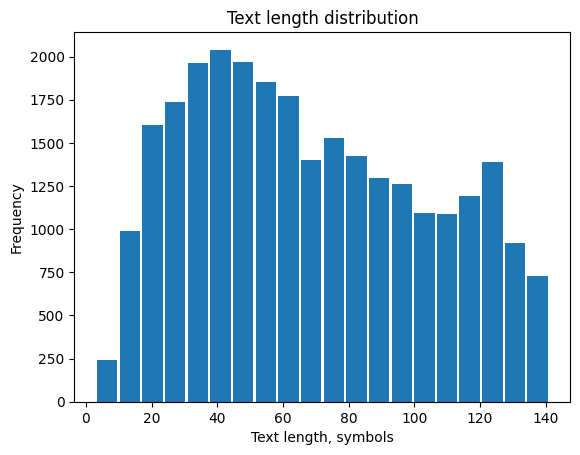

In [36]:
# Plot text length histogram

plt.hist(raw_df.text_len, bins=20, rwidth=0.9)
plt.title('Text length distribution')
plt.xlabel('Text length, symbols')
plt.ylabel('Frequency')
plt.xticks(np.arange(0,160,20))
plt.show();

**Conclusions**

1. The distribution of text lengths is right-skewed, with a higher frequency of shorter values (20–70 characters), and a decreasing number of tweets as text length increases. However, there is a notable increase in frequency around the 75-80 and 120–125 character ranges.
1. There is no significant class imbalance in the dataset.

### Step 3. Text Preprocessing and Bag-of-Words Vectorization

The goal here is to obtain vector representations of the text using the bag-of-words method. Text preprocessing will include:

* removing stopwords;
* tokenizing by splitting the text into single-word fragments;
* applying word stemming using SnowballStemmer.

In [37]:
# Download NLTK resources

nltk.download('punkt')
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')
link_substrings = ['.net', '.com', '.org', 'www.', 'http','bit.ly']

# Define tokenizer and stemmer function

def tokenize_and_stem(text):
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in english_stopwords]
  tokens = [stemmer.stem(word).lower() for word in tokens]
  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Define vectorizer

count_vectorizer = CountVectorizer(tokenizer=tokenize_and_stem)
count_vectorizer.fit(raw_df.text)
vocabulary = count_vectorizer.get_feature_names_out()
print(f'Vocabulary contains {len(vocabulary)} words')

inputs = count_vectorizer.transform(raw_df.text)
print(f'Shape of text vector representation: {inputs.shape}')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vocabulary contains 23154 words
Shape of text vector representation: (27480, 23154)


### Step 4. Building the Classifier

At this stage, we plan to:

* Split the data indices into training and testing sets;
* Train classifiers on the data. We will experiment with several models and select the one with the best metric value.



In [12]:
# Create train and test sets

X_train_bow, X_test_bow, y_train, y_test = train_test_split(inputs, raw_df.sentiment, test_size=0.3, random_state=42)

In [13]:
X_train_bow.shape, X_test_bow.shape

((19236, 23154), (8244, 23154))

In [14]:
# Define predict function

def predict_and_metrics(classifier, X, y, str):
  y_proba = classifier.predict_proba(X)
  y_proba = np.nan_to_num(y_proba)
  y_predict = [classifier.classes_[i] for i in y_proba.argmax(axis=1)]
  print(f'Classification report on {str} set')
  print(classification_report(y, y_predict))
  return classifier, y_proba, y_predict

#### Logistic Regression

In [15]:
classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=2000))
classifier.fit(X_train_bow, y_train)

classifier, ovr_log_proba_train, ovr_log_predict_train = predict_and_metrics(classifier, X_train_bow, y_train, 'train')
classifier, ovr_log_proba_test, ovr_log_predict_test = predict_and_metrics(classifier, X_test_bow, y_test, 'test')

Classification report on train set
              precision    recall  f1-score   support

    negative       0.89      0.84      0.86      5425
     neutral       0.84      0.89      0.86      7774
    positive       0.89      0.88      0.89      6037

    accuracy                           0.87     19236
   macro avg       0.88      0.87      0.87     19236
weighted avg       0.87      0.87      0.87     19236

Classification report on test set
              precision    recall  f1-score   support

    negative       0.71      0.59      0.65      2356
     neutral       0.64      0.73      0.68      3343
    positive       0.75      0.73      0.74      2545

    accuracy                           0.69      8244
   macro avg       0.70      0.68      0.69      8244
weighted avg       0.69      0.69      0.69      8244



####Decision Trees

In [16]:
classifier_dt = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
classifier_dt.fit(X_train_bow, y_train)
classifier_df, ovr_dt_proba_train, ovr_dt_predict_train = predict_and_metrics(classifier_dt, X_train_bow, y_train,'train')
classifier_df, ovr_dt_proba_test, ovr_dt_predict_test = predict_and_metrics(classifier_dt, X_test_bow, y_test,'test')

Classification report on train set
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      5425
     neutral       1.00      1.00      1.00      7774
    positive       1.00      1.00      1.00      6037

    accuracy                           1.00     19236
   macro avg       1.00      1.00      1.00     19236
weighted avg       1.00      1.00      1.00     19236

Classification report on test set


/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:551: RuntimeWarning: invalid value encountered in divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


              precision    recall  f1-score   support

    negative       0.50      0.73      0.59      2356
     neutral       0.67      0.57      0.62      3343
    positive       0.77      0.59      0.67      2545

    accuracy                           0.62      8244
   macro avg       0.65      0.63      0.63      8244
weighted avg       0.65      0.62      0.63      8244



####Random Forest

In [17]:
classifier_rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=35, max_leaf_nodes=200, n_jobs=-1, random_state=42))
classifier_rf.fit(X_train_bow, y_train)

classifier_rf, ovr_rf_proba_train, ovr_rf_predict_train = predict_and_metrics(classifier_rf, X_train_bow, y_train,'train')
classifier_rf, ovr_rf_proba_test, ovr_rf_predict_test = predict_and_metrics(classifier_rf, X_test_bow, y_test,'test')

Classification report on train set
              precision    recall  f1-score   support

    negative       0.84      0.57      0.68      5425
     neutral       0.65      0.83      0.73      7774
    positive       0.79      0.74      0.77      6037

    accuracy                           0.73     19236
   macro avg       0.76      0.71      0.72     19236
weighted avg       0.75      0.73      0.73     19236

Classification report on test set
              precision    recall  f1-score   support

    negative       0.77      0.49      0.60      2356
     neutral       0.61      0.79      0.69      3343
    positive       0.75      0.72      0.74      2545

    accuracy                           0.68      8244
   macro avg       0.71      0.67      0.67      8244
weighted avg       0.70      0.68      0.68      8244



The best performance among the three models was achieved by Logistic Regression, which yielded an F1 macro average of 0.69 on the test set. A closely comparable result was obtained by the Random Forest model, with an F1 macro average of 0.67 on the test set. The Decision Tree model exhibited overfitting, achieving an F1 score of 1 on the training set, but significantly lower on the test set.


### Step 5. Analyzing Word Influence in the Classifier

At this stage, we will:

* Conduct an analysis of word (feature) importance for the best model to determine which words (tokens) have the greatest impact on sentiment classification.
* Analyse whether it is logical that these specific tokens have the highest or lowest influence on sentiment prediction.

In [18]:
# Define feature importance evaluation function

def feature_importance(vectorizer, classifier):
  feature_imp_index = vectorizer.get_feature_names_out()
  importance = np.array([estimator.coef_ for estimator in classifier.estimators_]).T.squeeze()
  importance_df = pd.DataFrame(importance, index=feature_imp_index, columns=classifier.classes_)
  for class_ in classifier.classes_:
    print(f'\n10 most influential tokens for the class: {class_}')
    display(importance_df[class_].sort_values(ascending=False).head(10))
    print(f'\n10 least influential tokens for the class: {class_}')
    display(importance_df[class_].sort_values(ascending=False).tail(10))
  return importance_df

In [19]:
importance_bow = feature_importance(count_vectorizer, classifier)


10 most influential tokens for the class: negative


,negative
sad,3.054865
suck,3.052153
bore,2.964356
fail,2.782590
headach,2.679457
miss,2.670627
sorri,2.619135
stupid,2.539083
hate,2.500772
worst,2.486444



10 least influential tokens for the class: negative


,negative
congrat,-1.996095
great,-1.997666
enjoy,-2.021654
welcom,-2.039581
amaz,-2.067177
cute,-2.139972
love,-2.514560
glad,-2.539428
thank,-2.675492
awesom,-2.998589



10 most influential tokens for the class: neutral


,neutral
parvo,2.026326
hummmmm,1.629261
jst,1.526422
longest,1.482515
cop,1.437732
nigga,1.416467
starwarsday,1.402805
3.,1.387371
shoulder,1.382668
fals,1.374414



10 least influential tokens for the class: neutral


,neutral
fail,-1.699307
interest,-1.713135
proud,-1.713239
delici,-1.771392
wtf,-1.779504
happi,-1.878852
thank,-1.899402
troubl,-1.977928
headach,-1.990862
congratul,-2.096914



10 most influential tokens for the class: positive


,positive
awesom,3.286722
thank,3.262044
cute,3.083267
amaz,2.818992
nice,2.804089
great,2.779988
excit,2.757113
love,2.754291
happi,2.742885
enjoy,2.690990



10 least influential tokens for the class: positive


,positive
tire,-2.207289
poor,-2.263185
miss,-2.278021
unfortun,-2.436280
bore,-2.513211
hate,-2.560340
sorri,-2.613645
suck,-2.768723
shame,-2.970036
sad,-3.023428


**Conclusions**

The influence of tokens on class assignment looks entirely logical:

* Words with strong positive (e.g., awesome, amazing, great, exciting) and negative (e.g., sucks, boring, hate, worst) emotional tones significantly impact the classification of text as belonging to the positive or negative class.

### Step 6. Text Vectorization Using TF-IDF, Classifier Training, Word influence analysis

At this stage, we will:

* Vectorize the texts using Tf-IDF Vectorizer.
*Train the best classifier on TF-IDF vectors.
* Analyze classification quality by displaying relevant metrics to determine if the classification accuracy has improved.
* Identify the tokens with the highest influence when training the classifier with TF-IDF vectors.
* Compare these with the most influential tokens identified with Bag of Words vectorization.

In [20]:
# Create TF-IDF vectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_stem)
tfidf_vectorizer.fit(raw_df.text)
tfidf_inputs = tfidf_vectorizer.transform(raw_df.text)

X_train_tfidf = tfidf_inputs[y_train.index.tolist()]
X_test_tfidf = tfidf_inputs[y_test.index.tolist()]

# Create Logistic Regression classifier

classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=2000))
classifier.fit(X_train_tfidf, y_train)

classifier, ovr_log_proba_train, ovr_log_predict_train = predict_and_metrics(classifier, X_train_tfidf, y_train, 'train')
classifier, ovr_log_proba_test, ovr_log_predict_test = predict_and_metrics(classifier, X_test_tfidf, y_test, 'test')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Classification report on train set
              precision    recall  f1-score   support

    negative       0.83      0.70      0.76      5425
     neutral       0.72      0.84      0.77      7774
    positive       0.84      0.77      0.80      6037

    accuracy                           0.78     19236
   macro avg       0.79      0.77      0.78     19236
weighted avg       0.79      0.78      0.78     19236

Classification report on test set
              precision    recall  f1-score   support

    negative       0.73      0.55      0.63      2356
     neutral       0.62      0.77      0.69      3343
    positive       0.76      0.70      0.73      2545

    accuracy                           0.68      8244
   macro avg       0.70      0.67      0.68      8244
weighted avg       0.70      0.68      0.68      8244



In [21]:
# Analyse token importance

importance_tfidf = feature_importance(tfidf_vectorizer, classifier)


10 most influential tokens for the class: negative


,negative
miss,7.435915
sad,7.326191
suck,6.191079
sorri,5.998740
hate,5.851322
bore,5.406217
fail,4.774339
sick,4.651070
stupid,4.585734
hurt,4.573747



10 least influential tokens for the class: negative


,negative
glad,-2.930175
lol,-2.969540
good,-3.134580
happi,-3.245780
nice,-3.741546
great,-4.073277
hope,-4.286565
awesom,-4.412986
thank,-5.728175
love,-6.373518



10 most influential tokens for the class: neutral


,neutral
?,1.714131
lol,1.441253
though,1.436294
except,1.408850
check,1.398079
hey,1.303325
msn,1.290658
thru,1.286092
tho,1.257414
bound,1.228436



10 least influential tokens for the class: neutral


,neutral
suck,-3.630851
miss,-3.684573
awesom,-3.721631
nice,-4.112978
sad,-4.200995
great,-4.326586
good,-4.456095
love,-4.805690
happi,-5.175701
thank,-5.224229



10 most influential tokens for the class: positive


,positive
love,8.890827
thank,8.297467
great,6.929293
happi,6.825883
good,6.735349
awesom,6.612672
nice,6.590724
hope,5.634073
amaz,4.975229
enjoy,4.939683



10 least influential tokens for the class: positive


,positive
sick,-2.701329
poor,-2.914094
bad,-3.104748
bore,-3.491657
tire,-3.628382
hate,-3.999216
suck,-4.044095
sorri,-4.261135
sad,-5.224518
miss,-5.593393


**Висновки**

* The most influential features were the same when using both vectorization methods.

# Step 7. Error Analysis of TF-IDF Classification

* We will analyze the instances where the classifier made errors when using TF-IDF vectorization.

In [22]:
y_results = pd.DataFrame(y_test)
y_results.rename(columns={'sentiment': 'sent_test'}, inplace=True)
y_results['sent_pred'] = ovr_log_predict_test
y_results['text'] = raw_df.loc[y_results.index].text
y_mistakes = y_results[y_results['sent_test']!=y_results['sent_pred']]

In [23]:
y_mistakes[y_mistakes['sent_test']=='negative'].head(20)

,sent_test,sent_pred,text
10413,negative,neutral,"--of them kinda turns me off of it all. And then I buy more of them and dig a deeper hole, etc. ;;"
6717,negative,neutral,At work... What a miserable day
2830,negative,positive,I wish I had company
16792,negative,neutral,"Intel gfx driver situation much better with recent upgrades. kernel 2.6.30rc4 and driver from git: Suspend working again, fewer mem leaks"
20027,negative,neutral,Yep! Tail between legs!
23913,negative,neutral,waiting to go to the movies later for my 6th month. booored.
852,negative,neutral,i would slip and fall... on the dirty school bathroom floor. fml.
17617,negative,neutral,"as a kid, i remember searching with the local video store owner in a godown , got a video tape with fungus badluck"
10548,negative,neutral,so had a freakin lond thursday ready to hit the hay and surprise surprise I can`t freakin sleep :/ Boo!
14061,negative,neutral,R.I.P little bird that flew into my window snapping his neck


In [24]:
y_mistakes[y_mistakes['sent_test']=='neutral'].head(20)

,sent_test,sent_pred,text
10881,neutral,positive,. Well gotdamn girl!!! I dont know what else!!!! I`m sleepy again! Grrr
20883,neutral,negative,Is sad clint hurdle got released. I liked him
8786,neutral,positive,"oh i wish my dear Michael, i wish"
24375,neutral,positive,"haha! thanks, Tiff it went well, but they WORE ME OUT!!! lol. im too old for this ;)"
14979,neutral,negative,"they are, aren`t they."
15582,neutral,positive,http://twitpic.com/67kb6 - Sad day! What a great guy and enthusiastic teacher.
11326,neutral,positive,RAIN why must you come 'after' I flat iron my hair? I have been rockin my curls for 3 weeks and today you decide to come out. not nice!
20247,neutral,positive,Yey! holiday Monday in Uk today ... have a chilled day
13505,neutral,positive,****... long shift tonight... I really should sleep but I`m not tired. Had a nice talk with Jon after work Gotta love that boy!
626,neutral,positive,I agree. Everybody would`ve been excited and then it goes... ohhhh nooooo..... MS screws up again..


In [25]:
y_mistakes[y_mistakes['sent_test']=='positive'].head(30)

,sent_test,sent_pred,text
4890,positive,neutral,xD hello that`s an important date!
17381,positive,negative,FYI no internets until THURSTAG!!!! after saturday i have a feeling i will become 800x more productive during those days.
17117,positive,neutral,is helping making a twitter account
1227,positive,neutral,I LLLOOOVVVEEE ICARLY
20330,positive,neutral,it always rains right after i get my car washed
14603,positive,neutral,45Th st pub anyone tonight? Dont want to be a lonely drunk tonight
22807,positive,neutral,Why don`t we close the library due to the great weather? And the ac isn`t working #fb
18846,positive,neutral,I just got home. i bought twiggies and a toothbrush that promises to make my teeth 60% cleaner. - http://tweet.sg
5199,positive,neutral,Going to IKEA with the roomie so she can shop for her apartment. IKEA is in like my top ten stores that I love
312,positive,neutral,DUSTBIN BABY ON AT 11.30 Cannot wait x


In [26]:
print('Class-specific misclassification analysis on the test set:')
for class_ in classifier.classes_:
  print(class_, y_mistakes[y_mistakes['sent_test']==class_].shape[0])

Class-specific misclassification analysis on the test set:
negative 1065
neutral 779
positive 762


In [27]:
raw_df[raw_df['text'].str.contains('optim')]

,textID,text,selected_text,sentiment,text_len
4085,c5b161e18e,"Colleague that 'helped' by creating his unit`s site in iWeb was NOT helpful. Trash code, 24 CSS files for a 4 page site, no optimizing.",NOT helpful.,negative,135
6799,2f4ce91118,167 SQL queries to display one single deal page on OzBargain. Looks like I`ll have fun optimising it! Bad bad Drupal...,fun,positive,120
16203,fc7e0cb9eb,"Some of the figures quoted are so wildly optimistic, they are the stuff of science fiction. A bit disapointed in CIBER and SABIP",A bit disapointed in CIBER and SABIP,negative,129
16996,fd762e3047,@ BeardBurk: Their being optimistic,optimistic,positive,35
20157,dba9cf5ecf,"err you can turn on optimized js+css & caching once we deploy the thing, but I hear what you`re saying","err you can turn on optimized js+css & caching once we deploy the thing, but I hear what you`re saying",neutral,103
22245,45c727ef30,I`m sorry to hear that. Here is my optimist: Things will get better. For all of us.,m sorry,negative,85
26073,53f7cd955b,i like the optimism,like,positive,20


**Directions for further project development:**

The model most frequently makes errors in the following cases:

* Misspellings or incorrect word forms (e.g., boooreeeddd, llooovveee) prevent the model from identifying such words. We should add preprocessing steps to handle these cases.
* Misclassification of words that have similar roots but different meanings like 'optimistic' (positive) and 'optimize' (may be positive, neutral or negative).
* Fixed expressions (e.g., wish me luck) that may be interpreted differently as single words versus phrases, or words like 'like' when used in contexts such as 'like smth'.

**Conclusions:**

1. Text vectorization was performed using the Bag of Words and TF-IDF methods.
1. Three classification models were built: logistic regression, decision trees, and random forest. The best results were achieved by logistic regression with an F1 macro average of 0.69, which is a decent result but could be improved, including through more in-depth text preprocessing.
1. The results were analyzed, and the most influential tokens for classification were identified. Directions for further development were also determined to improve classification quality.

